In [2]:
# import pandas, numpy, and matplotlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.graphics.gofplots import qqline
import scipy.stats as scistat
pd.set_option('display.width', 85)
pd.set_option('display.max_columns', 6)
pd.set_option('display.max_rows', 20)
pd.options.display.float_format = '{:,.0f}'.format
covidtotals = pd.read_csv("data/covidtotals.csv")
covidtotals.set_index("iso_code", inplace=True)
# set up the cumulative and demographic columns
totvars = ['location','total_cases','total_deaths','total_cases_pm',
  'total_deaths_pm']
demovars = ['population','pop_density','median_age','gdp_per_capita',
  'hosp_beds']


In [4]:



# get descriptive statistics on the cumulative values
covidtotalsonly = covidtotals.loc[:, totvars]
covidtotalsonly.describe()
pd.options.display.float_format = '{:,.2f}'.format
covidtotalsonly.quantile(np.arange(0.0, 1.1, 0.1))
covidtotalsonly.skew()
covidtotalsonly.kurtosis()

# test for normality
def testnorm(var, df):
  stat, p = scistat.shapiro(df[var])
  return p

testnorm("total_cases", covidtotalsonly)


3.753789128593843e-29

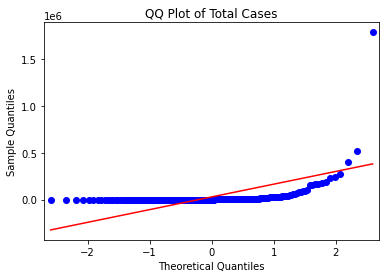

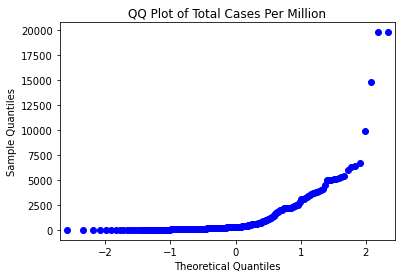

-14736.125 <--> 25028.875


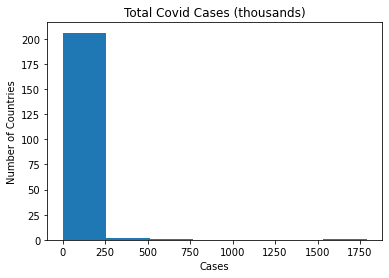

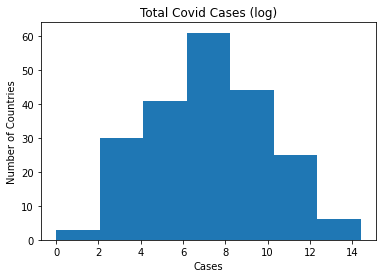

In [5]:
testnorm("total_deaths", covidtotalsonly)
testnorm("total_cases_pm", covidtotalsonly)
testnorm("total_deaths_pm", covidtotalsonly)

# show a qqplot for total cases and total cases per million
sm.qqplot(covidtotalsonly[['total_cases']]. \
  sort_values(['total_cases']), line='s')
plt.title("QQ Plot of Total Cases")

sm.qqplot(covidtotals[['total_cases_pm']]. \
  sort_values(['total_cases_pm']), line='s')
plt.title("QQ Plot of Total Cases Per Million")
plt.show()

# show outliers for total cases
thirdq, firstq = covidtotalsonly.total_cases.quantile(0.75), covidtotalsonly.total_cases.quantile(0.25)
interquartilerange = 1.5*(thirdq-firstq)
outlierhigh, outlierlow = interquartilerange+thirdq, firstq-interquartilerange
print(outlierlow, outlierhigh, sep=" <--> ")

# generate a table of outliers and save it to Excel
def getoutliers():
  dfout = pd.DataFrame(columns=covidtotals.columns, data=None)
  for col in covidtotalsonly.columns[1:]:
    thirdq, firstq = covidtotalsonly[col].quantile(0.75),\
      covidtotalsonly[col].quantile(0.25)
    interquartilerange = 1.5*(thirdq-firstq)
    outlierhigh, outlierlow = interquartilerange+thirdq,\
      firstq-interquartilerange
    df = covidtotals.loc[(covidtotals[col]>outlierhigh) | \
      (covidtotals[col]<outlierlow)]
    df = df.assign(varname = col, threshlow = outlierlow,\
       threshhigh = outlierhigh)
    dfout = pd.concat([dfout, df])
  return dfout

outliers = getoutliers()
outliers.varname.value_counts()
outliers.to_excel("views/outlierscases.xlsx")

# look a little more closely at outliers for cases per million
outliers.loc[outliers.varname=="total_cases_pm",\
  ['location','total_cases_pm','pop_density','gdp_per_capita']].\
  sort_values(['total_cases_pm'], ascending=False)

covidtotals[['pop_density','gdp_per_capita']].quantile([0.25,0.5,0.75])

# show the total cases histogram again
plt.hist(covidtotalsonly['total_cases']/1000, bins=7)
plt.title("Total Covid Cases (thousands)")
plt.xlabel('Cases')
plt.ylabel("Number of Countries")
plt.show()

# do a log transformation of the covid data
covidlogs = covidtotalsonly.copy()
for col in covidtotalsonly.columns[1:]:
  covidlogs[col] = np.log1p(covidlogs[col])

plt.hist(covidlogs['total_cases'], bins=7)
plt.title("Total Covid Cases (log)")
plt.xlabel('Cases')
plt.ylabel("Number of Countries")
plt.show()
